    Cross-over strategy is backtested here,
    Strategy is checked with various moving average parameters, through grid-search 
    Also same stretegy is checked with different assets. 
    Last update Oct 2021

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import pyfolio as pf

/home/soma/.local/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
class backtesting_crossover:
    
    def __init__(self, ticker, start_date, end_date , ma_short, ma_long):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.ma_short = ma_short
        self.ma_long = ma_long
        self.fetch_data()
        self.indicators()
        self.signals()
        self.positions()
        self.returns()
        
    def fetch_data(self):
        self.df = yf.download(self.ticker, self.start_date, self.end_date)
        
    def indicators(self):
        self.df['ma_short'] = self.df['Adj Close'].rolling(window= self.ma_short, center=False).mean()
        self.df['ma_long'] = self.df['Adj Close'].rolling(window= self.ma_long, center=False).mean()
        self.df['ma_short_prev'] = self.df['ma_short'].shift()
        self.df['ma_long_prev'] = self.df['ma_long'].shift()
        self.df.dropna(inplace=True)
   
    def signals(self):
        self.df['signal'] = np.where((self.df['ma_short'] > self.df['ma_long']) 
                            & (self.df['ma_short_prev'] < self.df['ma_long_prev']), 1, 0)
        
        self.df['signal'] = np.where((self.df['ma_short'] < self.df['ma_long']) 
                            & (self.df['ma_short_prev'] > self.df['ma_long_prev']), -1, self.df['signal'])
    
    def positions(self):
        self.df['position'] = self.df['signal'].replace(to_replace=0, method='ffill')
        
    def returns(self):
        self.df['bnh_returns'] = np.log(self.df['Adj Close'] / self.df['Adj Close'].shift(1))
        self.df['strategy_returns'] = self.df['bnh_returns'] * self.df['position'].shift(1)
        print('Total return:',self.df['strategy_returns'].cumsum()[-1] )
        return self.df['strategy_returns'].cumsum()[-1]
       
    def analysis(self):
        # A plot to check if the strategy is working as planned:
        self.df[['ma_short','ma_long', 'position']].plot(figsize=(15, 6), secondary_y='position', grid=True)
        plt.title('checking if positions are generated properly')
        plt.show()

        # A plot to check how the strategy strategy performs relative to buy & hold
        self.df[['bnh_returns','strategy_returns']].cumsum().plot(figsize=(15, 6), secondary_y='position', grid=True)
        plt.title("Buy & hold' vs 'crossover strategy' cumulative returns")
        plt.show()

        # general analytics
        pf.create_simple_tear_sheet(self.df['strategy_returns'])

In [3]:
# Create start and end dates for the past 252 days
end1 = dt.datetime(2022,1,1).date()
start1 = end1-pd.Timedelta(days=3*252)
start1 ,end1

(datetime.date(2019, 12, 7), datetime.date(2022, 1, 1))

In [4]:
# Performance of the strategy with Nifty 50 index, with ma_short = 8 and ma_long = 20
nifty_10_20 = backtesting_crossover('^NSEI', start1, end1, 8, 20)

[*********************100%***********************]  1 of 1 completed
Total return: 0.14031680998065027


In [5]:
# Performance of the strategy with Nifty 50 index, with ma_short = 5 and ma_long = 20
nifty_5_20 = backtesting_crossover('^NSEI', start1, end1, 5, 20)

[*********************100%***********************]  1 of 1 completed
Total return: 0.33820659929885727


In [6]:
# Performance of the strategy with Nifty Bank index, with ma_short = 5 and ma_long = 20
Banking_5_20 = backtesting_crossover('^NSEBANK', start1, end1, 5, 20)

[*********************100%***********************]  1 of 1 completed
Total return: 0.38144584588669006


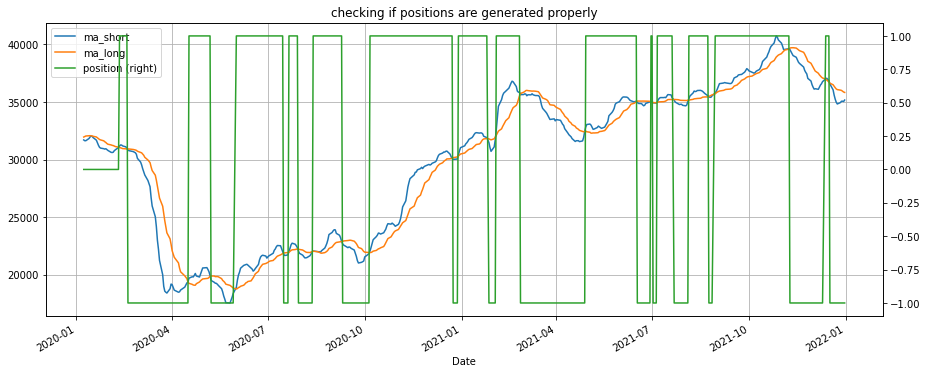

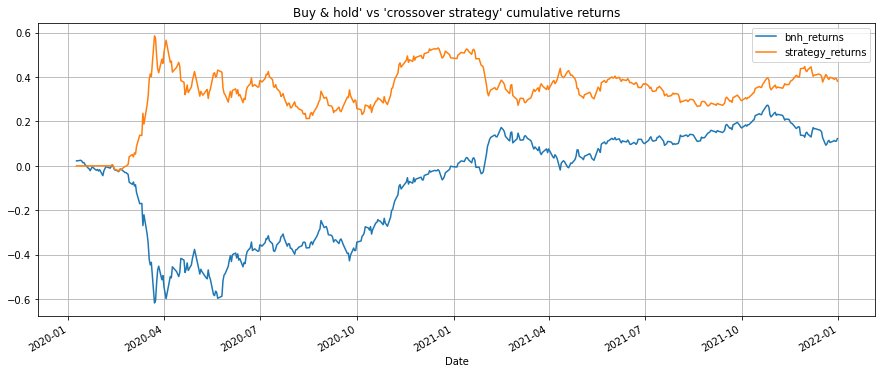

Start date,2020-01-08
End date,2021-12-31
Total months,23
,Backtest
Annual return,14.5%
Cumulative returns,30.2%
Annual volatility,35.0%
Sharpe ratio,0.56
Calmar ratio,0.42
Stability,0.03
Max drawdown,-34.2%


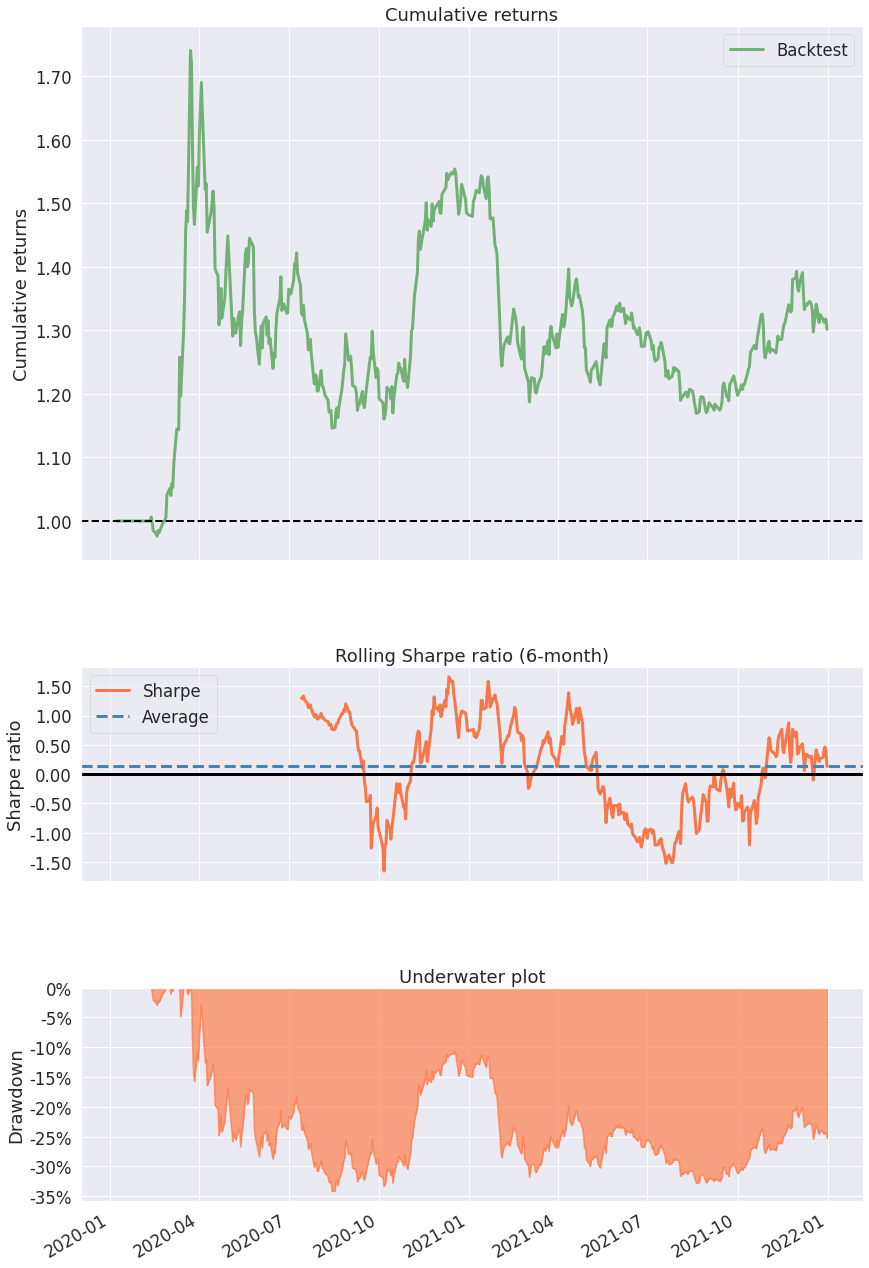

In [7]:
# Plots to check strategy return, positions taken
Banking_5_20.analysis()

In [8]:
# Define new indicator for EMA and inherit all methods from parent
class backtesting_EMA_crossover(backtesting_crossover):
    def indicators(self):
        self.df['ma_short'] = self.df['Adj Close'].ewm(span= self.ma_short, adjust=False).mean()
        self.df['ma_long'] = self.df['Adj Close'].ewm(span= self.ma_long, adjust=False).mean()
        self.df['ma_short_prev'] = self.df['ma_short'].shift()
        self.df['ma_long_prev'] = self.df['ma_long'].shift()
        self.df.dropna(inplace=True)
        

In [9]:
# Check EMA performance for NSE index
nifty_5_20_ema = backtesting_EMA_crossover('^NSEI', start1, end1, 5, 20)

[*********************100%***********************]  1 of 1 completed
Total return: 0.2856200599201077


In [10]:
# Check EMA performance for Nifty Bank index
Banking_5_20_ema = backtesting_EMA_crossover('^NSEBANK', start1, end1, 5, 20)

[*********************100%***********************]  1 of 1 completed
Total return: 0.40290292916362846


In [11]:
# Check performance for AAPL
apple_10_20_ema = backtesting_EMA_crossover('AAPL', start1, end1, 10, 20)

[*********************100%***********************]  1 of 1 completed
Total return: 1.0126495784839162


### Brute-force with possible parameters - Grid search

In [12]:
fast_ma_list =[5,10,15,20]
slow_ma_list =[25,50,100]

fast_ma=[]
slow_ma=[]
net_returns= []

for i in fast_ma_list:
    for j in slow_ma_list:
        print('For',i,j)
        a = backtesting_EMA_crossover('AAPL', start1, end1, i, j)
        fast_ma.append(i)
        slow_ma.append(j)
        net_returns.append(a.returns())

For 5 25
[*********************100%***********************]  1 of 1 completed
Total return: 1.044671639549856
Total return: 1.044671639549856
For 5 50
[*********************100%***********************]  1 of 1 completed
Total return: 0.5313523930630273
Total return: 0.5313523930630273
For 5 100
[*********************100%***********************]  1 of 1 completed
Total return: 0.3261755218132186
Total return: 0.3261755218132186
For 10 25
[*********************100%***********************]  1 of 1 completed
Total return: 0.6797114957222765
Total return: 0.6797114957222765
For 10 50
[*********************100%***********************]  1 of 1 completed
Total return: 0.33091498274227205
Total return: 0.33091498274227205
For 10 100
[*********************100%***********************]  1 of 1 completed
Total return: 0.5955363942884224
Total return: 0.5955363942884224
For 15 25
[*********************100%***********************]  1 of 1 completed
Total return: 0.4890134638731281
Total return: 0.489

In [13]:
#Convert to DataFrame and sort it
results = pd.DataFrame({'fast_ma':fast_ma,'slow_ma': slow_ma,'net_returns':net_returns})
results.sort_values(by='net_returns',ascending=False, inplace=True)
results

,fast_ma,slow_ma,net_returns
0,5,25,1.044672
8,15,100,0.692215
3,10,25,0.679711
10,20,50,0.604221
5,10,100,0.595536
7,15,50,0.571663
1,5,50,0.531352
6,15,25,0.489013
11,20,100,0.377494
4,10,50,0.330915


### Testing the strategy with various assets

In [14]:
stock_list = [   'BAJFINANCE.NS',
                 'BAJAJFINSV.NS',
                 'BPCL.NS',
                 'BHARTIARTL.NS',
                 'INDUSTOWER.NS',
                 'BRITANNIA.NS',
                 'CIPLA.NS',
                 'COALINDIA.NS',
                 'DRREDDY.NS',
                 'EICHERMOT.NS',
                 'GAIL.NS',
                 'GRASIM.NS'  ]

stock_name = []
net_returns = []

In [15]:
 for stock in stock_list:
        print('Backtesting result for',stock)
        a = backtesting_EMA_crossover(stock, start1, end1, 5, 20)
        stock_name.append(stock)
        net_returns.append(a.returns())

Backtesting result for BAJFINANCE.NS
[*********************100%***********************]  1 of 1 completed
Total return: 1.2773812433372087
Total return: 1.2773812433372087
Backtesting result for BAJAJFINSV.NS
[*********************100%***********************]  1 of 1 completed
Total return: 1.4123680486694452
Total return: 1.4123680486694452
Backtesting result for BPCL.NS
[*********************100%***********************]  1 of 1 completed
Total return: -0.1265352004955661
Total return: -0.1265352004955661
Backtesting result for BHARTIARTL.NS
[*********************100%***********************]  1 of 1 completed
Total return: 0.6565031291986628
Total return: 0.6565031291986628
Backtesting result for INDUSTOWER.NS
[*********************100%***********************]  1 of 1 completed
Total return: -0.023988920345183403
Total return: -0.023988920345183403
Backtesting result for BRITANNIA.NS
[*********************100%***********************]  1 of 1 completed
Total return: 0.45446105233294004

In [16]:
results = pd.DataFrame({'Stock':stock_name,'net_returns':net_returns})
results.sort_values(by='net_returns',ascending=False, inplace=True)

In [17]:
results

,Stock,net_returns
1,BAJAJFINSV.NS,1.412368
0,BAJFINANCE.NS,1.277381
11,GRASIM.NS,1.252600
3,BHARTIARTL.NS,0.656503
5,BRITANNIA.NS,0.454461
8,DRREDDY.NS,0.371940
10,GAIL.NS,0.302869
9,EICHERMOT.NS,0.247361
7,COALINDIA.NS,0.186268
4,INDUSTOWER.NS,-0.023989
